# Main class definition

In [1]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
 
class Data:
    def __init__(self, DropCol = None, DropRow = None, DropRowEpsilon = 0, EncConfig = None,
                 TempType = 'Cat', TempScal = 'Robust', DropSpCol = True, ImputeMissing=False): #'OneHot' -> all categorical columns with One Hot; 'Num' -> all categorical columns  0,1,2..; Dict_type -> writing which columns how
        self.DataName = 'in-vehicle-coupon-recommendation.csv'
        self.Data = None
        
        self.DecColumn = None
        self.Columns = None
        self.CatColumns = ['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age', 'maritalStatus', \
                          'education', 'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', ]
        self.OrdCatColumns = {'temperature': ['30','55','80'], 'time':['7AM', '10AM', '2PM', '6PM', '10PM'],\
                              'age': ['below21', '21', '26', '31', '36', '41', '46', '50plus'],\
                              'income': ['Less than $12500', '$12500 - $24999', '$25000 - $37499', '$37500 - $49999',\
                                        '$50000 - $62499', '$62500 - $74999', '$75000 - $87499', '$87500 - $99999', '$100000 or More'],\
                              'Bar': ['never', 'less1', '1~3','4~8', 'gt8'],\
                              'CoffeeHouse': ['never', 'less1', '1~3','4~8', 'gt8'],\
                              'CarryAway': ['never', 'less1', '1~3','4~8', 'gt8'],\
                              'RestaurantLessThan20': ['never', 'less1', '1~3', '4~8', 'gt8'],\
                              'Restaurant20To50': ['never', 'less1', '1~3','4~8', 'gt8']}
        self.BinColumns = ['has_children', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same', 'direction_opp']
        self.NumColumns = []

        self.TemperatureType = TempType
        self.TemperatureScaler = TempScal
        self.DropSpetialFeature = DropSpCol

        self.DropColumns = DropCol
        self.DropRows = DropRow
        self.DropRowsEpsilon = DropRowEpsilon
        self.ImputeMissing = ImputeMissing
        self.EncConfiguration = EncConfig
    
    def setSetting(self, data):
        self.Columns = data.columns.tolist()
        if self.TemperatureType == 'Cat': self.CatColumns.append('temperature')
        elif self.TemperatureType == 'Num': self.NumColumns.append('temperature') 
        else:
            print('Error: Wrong type of "temperature" column.')
            return False
        if not self.DropSpetialFeature: 
            self.BinColumns.append('toCoupon_GEQ5min')
        else:
            if self.DropColumns is None:
                self.DropColumns = ['toCoupon_GEQ5min']
            else:
                self.DropColumns.append('toCoupon_GEQ5min')
        
        if self.EncConfiguration is None:
            return True
        elif self.EncConfiguration == 'OneHot':
            self.EncConfiguration = {c: 'OneHot' for c in self.Columns}
            return True
        elif self.EncConfiguration == 'Num':
            self.EncConfiguration = {c: 'Num' for c in self.Columns}
            return True
        elif isinstance(self.EncConfiguration, dict):
            self.EncConfiguration = {c: self.EncConfiguration[c] if c in self.EncConfiguration.keys() else None  for c in self.Columns}
            return True
        else:
            print('Error: Wrong insterted type!')
            return False

    def GetFreq(self, data):
        Col = data.columns
        Dict = {}
        for c in Col:
            Atr = dict(data[c].value_counts(normalize=True))
            Atr = {str(c): Atr[c] for c in Atr}
            Dict[c] = Atr
        return Dict

    def GetEpsilonFeature(self, data, epsilon):
        Dict = self.GetFreq(data)
        del Dict['Y']
        Col = Dict.keys()
        List = []
        for c in Col:
            for f in Dict[c].keys():
                List.append((c,f,Dict[c][f]))
        List.sort(key = lambda x:x[2])
        EpsilonFeatures = []
        for p in List:
            if p[2] < epsilon:
                EpsilonFeatures.append((p[0], p[1]))
            else: break
        return EpsilonFeatures

    def DropCol(self, data):
        for c in self.DropColumns:
            data = data.drop(c, axis = 1)
        return data

    def DropRow(self, data):
        if self.DropRowsEpsilon > 0:
            ToRemove = self.GetEpsilonFeature(data, self.DropRowsEpsilon)
            NewData = data.copy()
            for k in ToRemove:
                NewData = NewData[NewData[k[0]] != k[1]]
            NewData = NewData.reset_index(drop=True)
            return NewData
        elif self.DropRows is not None:
            ToRemove = self.DropRows
            NewData = data.copy()
            for k in ToRemove:
                NewData = NewData[NewData[k[0]] != k[1]]
            NewData = NewData.reset_index(drop=True)
            return NewData
        else: return data
    
    def DropNaN(self, data):
        data = data.drop('car', axis = 1)
        # NanRow = data[data.isna().any(axis=1)]

        # Optionally, impute the missing values instead of dropping them
        if self.ImputeMissing:
            for col in data.columns:
                if data[col].isna().any(): # if the column contains NaNs
                    # Fill the NaNs either with the mode value, if it's categorical/binary column
                    if col in self.CatColumns + self.BinColumns:
                        data[col] = data[col].fillna(data[col].mode()[0])
                    # Or the median, if it's numerical
                    elif col in self.NumColumns:
                        data[col] = data[col].fillna(data[col].median())
        else: # Default behavior of dropping the remaining NaNs
            data = data.dropna()
        
        data = data.reset_index(drop=True)
        return data

    def SepDecision(self, data):
        self.DecColumn = data['Y']
        data = data.drop('Y', axis = 1)
        return data
    
    def Encoding(self, data):
        for c in self.CatColumns:
            if self.EncConfiguration[c] == 'OneHot':
                OneHotColumns = self.OneHot(data[[c]], c)
                index = data.columns.get_loc(c)
                data = data.drop(columns = c)

                ColsBef = data.columns[:index]
                ColsAft = data.columns[index:]
                
                data = pd.concat([data[ColsBef], OneHotColumns, data[ColsAft]], axis=1)
            elif self.EncConfiguration[c] == 'Num':
                data[c] = self.Num(data[c], c)
        return data
        
    def TempNumEncoding(self, data):
        print('IN')
        if self.TemperatureScaler == 'Robust':
            scaler = RobustScaler()
            scaled_temperature = scaler.fit_transform(data[['temperature']])
            data['temperature'] = scaled_temperature
        elif self.TemperatureScaler == 'Standard':
            scaler = StandardScaler()
            scaled_temperature = scaler.fit_transform(data[['temperature']])
            data['temperature'] = scaled_temperature
        else:
            return None
        return data

    def OneHot(self, Col, c):
        Encoder = OneHotEncoder(drop = 'first', sparse_output=False)
        EncCol = Encoder.fit_transform(Col)
        ColNames = Encoder.get_feature_names_out([c])
        OneHotColumns = pd.DataFrame(EncCol, columns = ColNames)
        return OneHotColumns

    def Num(self, Col, name):
        EncCol = []
        if name in self.OrdCatColumns.keys():
            EncCol = [self.OrdCatColumns[name].index(str(c)) for c in Col]
        else:
            UnqCol = Col.unique().tolist()
            EncDict = {c: UnqCol.index(c) for c in UnqCol}
            EncCol = [EncDict[c] for c in Col]
        return EncCol
            
    def fit(self):
        data = pd.read_csv(self.DataName)
        
        data = self.DropNaN(data)

        if (self.DropRows is not None) or (self.DropRowsEpsilon > 0):
            data = self.DropRow(data)
        
        data = self.SepDecision(data)

        if not self.setSetting(data): return None

        if self.DropColumns is not None: 
            data = self.DropCol(data)

        if self.EncConfiguration is not None: 
            data = self.Encoding(data)
        if self.TemperatureType == 'Num': data = self.TempNumEncoding(data)

        data['Y'] = self.DecColumn
        self.Data = data
        return data    

## Working examples

In [3]:
d1 = Data()
d1.fit()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Bar,1d,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Male,21,Single,...,never,less1,4~8,4~8,less1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12074,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,0,0,1,0,1
12075,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,0,0,0,1,1
12076,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,0,0,1,0,0
12077,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,1,0,1,0


In [6]:
# Removing the 'destination' and 'toCoupon_GEQ5min' (spetial column) columns

d2 = Data(DropCol = ['destination'], DropSpCol = True)
d2.fit()

,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,Alone,Sunny,55,2PM,Restaurant(<20),1d,Male,21,Single,0,...,never,less1,4~8,4~8,less1,0,0,0,1,1
1,Friend(s),Sunny,80,10AM,Coffee House,2h,Male,21,Single,0,...,never,less1,4~8,4~8,less1,0,0,0,1,0
2,Friend(s),Sunny,80,10AM,Bar,1d,Male,21,Single,0,...,never,less1,4~8,4~8,less1,0,0,0,1,1
3,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Male,21,Single,0,...,never,less1,4~8,4~8,less1,1,0,0,1,0
4,Friend(s),Sunny,80,2PM,Coffee House,1d,Male,21,Single,0,...,never,less1,4~8,4~8,less1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12074,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,0,...,never,never,1~3,4~8,1~3,0,0,1,0,1
12075,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,0,...,never,never,1~3,4~8,1~3,0,0,0,1,1
12076,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,0,...,never,never,1~3,4~8,1~3,0,0,1,0,0
12077,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,0,...,never,never,1~3,4~8,1~3,1,1,0,1,0


In [8]:
# Removing rows with low frequency features in colums with frequency < epsilon

d3 = Data(DropRowEpsilon = 0.01)
data = d3.fit()
data

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Bar,1d,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Male,21,Single,...,never,less1,4~8,4~8,less1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11703,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,0,0,1,0,1
11704,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,0,0,0,1,1
11705,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,0,0,1,0,0
11706,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,1,0,1,0


In [10]:
# Removing rows with low frequency features in colums with given list form: [(Column, Value), ...]

ToRemove = [('passanger', 'Alone')]
d4 = Data(DropRow = ToRemove)
data = d4.fit()
data

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,0
1,No Urgent Place,Friend(s),Sunny,80,10AM,Bar,1d,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,1
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Male,21,Single,...,never,less1,4~8,4~8,less1,1,0,0,1,0
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Male,21,Single,...,never,less1,4~8,4~8,less1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,No Urgent Place,Partner,Rainy,55,6PM,Bar,2h,Male,26,Single,...,never,never,1~3,4~8,1~3,1,0,0,1,0
5106,No Urgent Place,Partner,Snowy,30,10AM,Restaurant(<20),1d,Male,26,Single,...,never,never,1~3,4~8,1~3,0,0,0,1,1
5107,Home,Partner,Sunny,30,6PM,Restaurant(<20),1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,1,0,1,1
5108,Home,Partner,Sunny,30,10PM,Restaurant(<20),2h,Male,26,Single,...,never,never,1~3,4~8,1~3,1,0,1,0,0


In [12]:
# Removing and changing the encoding way

d5 = Data(DropCol = ['destination'], EncConfig = {'passanger': 'OneHot', 'weather': 'OneHot', 'temperature': 'Num'})
data = d5.fit()
data

,passanger_Friend(s),passanger_Kid(s),passanger_Partner,weather_Snowy,weather_Sunny,temperature,time,coupon,expiration,gender,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,0.0,0.0,0.0,0.0,1.0,1,2PM,Restaurant(<20),1d,Male,...,never,less1,4~8,4~8,less1,0,0,0,1,1
1,1.0,0.0,0.0,0.0,1.0,2,10AM,Coffee House,2h,Male,...,never,less1,4~8,4~8,less1,0,0,0,1,0
2,1.0,0.0,0.0,0.0,1.0,2,10AM,Bar,1d,Male,...,never,less1,4~8,4~8,less1,0,0,0,1,1
3,1.0,0.0,0.0,0.0,1.0,2,10AM,Carry out & Take away,2h,Male,...,never,less1,4~8,4~8,less1,1,0,0,1,0
4,1.0,0.0,0.0,0.0,1.0,2,2PM,Coffee House,1d,Male,...,never,less1,4~8,4~8,less1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12074,0.0,0.0,1.0,0.0,0.0,1,6PM,Carry out & Take away,1d,Male,...,never,never,1~3,4~8,1~3,0,0,1,0,1
12075,0.0,0.0,0.0,0.0,0.0,1,7AM,Carry out & Take away,1d,Male,...,never,never,1~3,4~8,1~3,0,0,0,1,1
12076,0.0,0.0,0.0,1.0,0.0,0,7AM,Coffee House,1d,Male,...,never,never,1~3,4~8,1~3,0,0,1,0,0
12077,0.0,0.0,0.0,1.0,0.0,0,7AM,Bar,1d,Male,...,never,never,1~3,4~8,1~3,1,1,0,1,0


In [17]:
print(f'{data['passanger_Friend(s)'][0]} is type {type(data['passanger_Friend(s)'][0])}')

0.0 is type <class 'numpy.float64'>


In [21]:
print(f'{data['passanger_Partner'][0]} is type {type(data['passanger_Partner'][0])}')

0.0 is type <class 'numpy.float64'>


In [23]:
print(f'{data['temperature'][0]} is type {type(data['temperature'][0])}')

1 is type <class 'numpy.int64'>


In [25]:
# Encoding all categorical features with 0,2,3... way

d6 = Data(EncConfig = 'Num')
data_num = d6.fit()
data_num

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,0,0,0,1,2,0,0,0,1,0,...,0,1,3,3,1,0,0,0,1,1
1,0,1,0,2,1,1,1,0,1,0,...,0,1,3,3,1,0,0,0,1,0
2,0,1,0,2,1,2,0,0,1,0,...,0,1,3,3,1,0,0,0,1,1
3,0,1,0,2,1,3,1,0,1,0,...,0,1,3,3,1,1,0,0,1,0
4,0,1,0,2,2,1,0,0,1,0,...,0,1,3,3,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12074,1,3,1,1,3,3,0,0,2,0,...,0,0,2,3,2,0,0,1,0,1
12075,2,0,1,1,0,3,0,0,2,0,...,0,0,2,3,2,0,0,0,1,1
12076,2,0,2,0,0,1,0,0,2,0,...,0,0,2,3,2,0,0,1,0,0
12077,2,0,2,0,0,2,0,0,2,0,...,0,0,2,3,2,1,1,0,1,0


In [27]:
print(f'{data_num['passanger'][0]} is type {type(data_num['passanger'][0])}')

0 is type <class 'numpy.int64'>


In [29]:
print(f'{data_num['temperature'][0]} is type {type(data_num['temperature'][0])}')

1 is type <class 'numpy.int64'>


In [31]:
d7 = Data(TempType = 'Num')
d7.fit()

IN


,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,-1.0,2PM,Restaurant(<20),1d,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,0.0,10AM,Coffee House,2h,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,0.0,10AM,Bar,1d,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,0.0,10AM,Carry out & Take away,2h,Male,21,Single,...,never,less1,4~8,4~8,less1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,0.0,2PM,Coffee House,1d,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12074,Home,Partner,Rainy,-1.0,6PM,Carry out & Take away,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,0,0,1,0,1
12075,Work,Alone,Rainy,-1.0,7AM,Carry out & Take away,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,0,0,0,1,1
12076,Work,Alone,Snowy,-2.0,7AM,Coffee House,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,0,0,1,0,0
12077,Work,Alone,Snowy,-2.0,7AM,Bar,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,1,0,1,0


In [33]:
d8 = Data(TempType = 'Num', TempScal = 'Standard')
d8.fit()

IN


,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,-0.435632,2PM,Restaurant(<20),1d,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,0.871048,10AM,Coffee House,2h,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,0.871048,10AM,Bar,1d,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,0.871048,10AM,Carry out & Take away,2h,Male,21,Single,...,never,less1,4~8,4~8,less1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,0.871048,2PM,Coffee House,1d,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12074,Home,Partner,Rainy,-0.435632,6PM,Carry out & Take away,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,0,0,1,0,1
12075,Work,Alone,Rainy,-0.435632,7AM,Carry out & Take away,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,0,0,0,1,1
12076,Work,Alone,Snowy,-1.742312,7AM,Coffee House,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,0,0,1,0,0
12077,Work,Alone,Snowy,-1.742312,7AM,Bar,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,1,0,1,0


In [35]:
d9 = Data(EncConfig='OneHot', ImputeMissing=True)
d9.fit()

,destination_No Urgent Place,destination_Work,passanger_Friend(s),passanger_Kid(s),passanger_Partner,weather_Snowy,weather_Sunny,temperature_55,temperature_80,time_10PM,...,RestaurantLessThan20_never,Restaurant20To50_4~8,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,1,1
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1
12680,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1
12681,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0
12682,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,0,1,0


# Decision tree dataset version

Here we'll construct and save the dataset for decision trees training. 

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [14]:
d1 = Data()
d1.fit()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Bar,1d,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Male,21,Single,...,never,less1,4~8,4~8,less1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Male,21,Single,...,never,less1,4~8,4~8,less1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12074,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,0,0,1,0,1
12075,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,0,0,0,1,1
12076,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,0,0,1,0,0
12077,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,1,0,1,0


In [16]:
preprocessed_data = Data(EncConfig='Num', ImputeMissing=True, DropSpCol=True)
data_for_decision_tree = preprocessed_data.fit()

In [19]:
X = data_for_decision_tree.drop("Y", axis = 1)
y = data_for_decision_tree['Y']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2, # 20% test size, 80% train size
    random_state=1, # for consistent dataset format
    stratify=y #sets proportion of accepted/rejected coupons to be the same in training and testing dataset
)

print("\nData preparation complete.")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Data preparation complete.
Training set shape: (10147, 23)
Testing set shape: (2537, 23)


In [22]:
model = DecisionTreeClassifier(random_state=1) # for consistent tree randomness
model.fit(X_train, y_train) # training the model

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,1
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Model Accuracy: 0.6969

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.63      0.64      1095
           1       0.73      0.74      0.74      1442

    accuracy                           0.70      2537
   macro avg       0.69      0.69      0.69      2537
weighted avg       0.70      0.70      0.70      2537

Confusion Matrix:


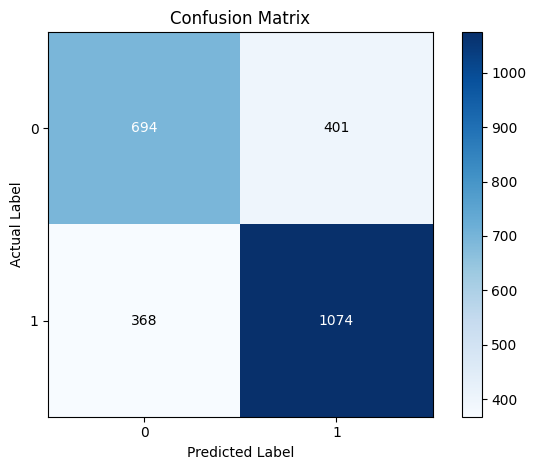

In [36]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=[0,1], yticklabels=[0,1],
       title='Confusion Matrix',
       ylabel='Actual Label',
       xlabel='Predicted Label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

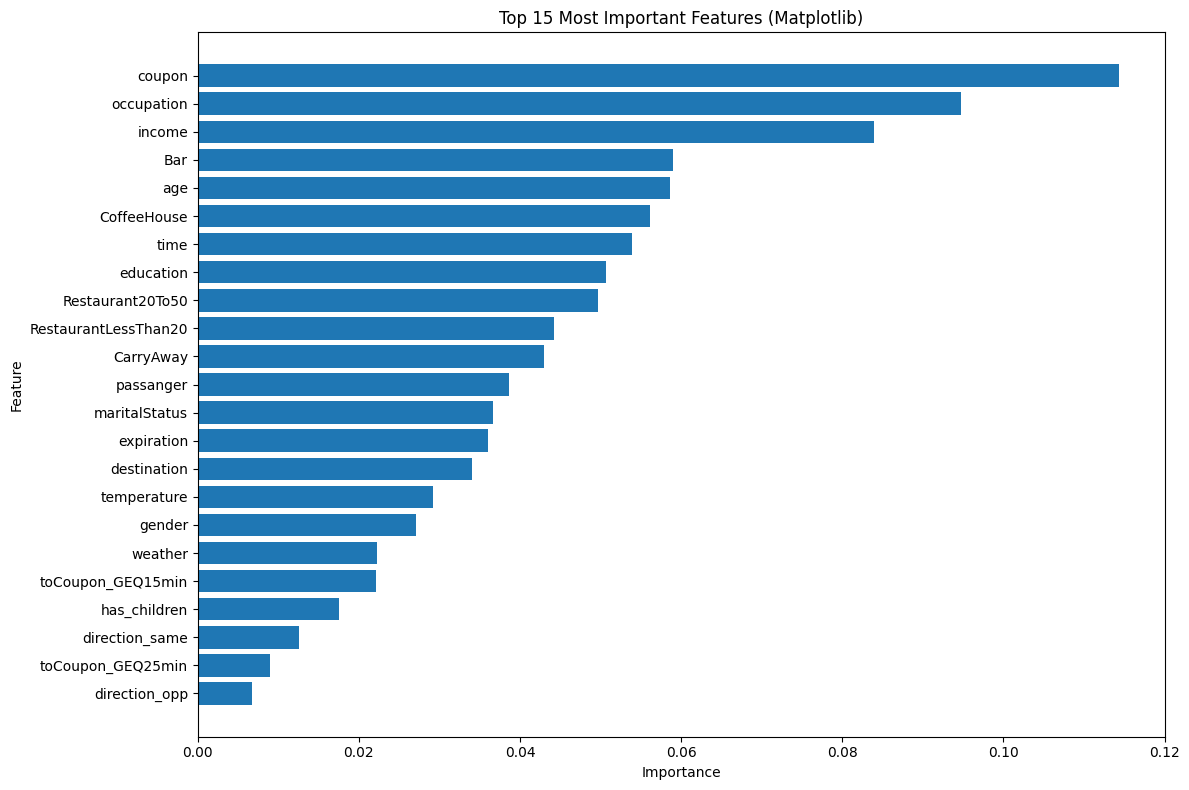

In [41]:
importances = model.feature_importances_
feature_names = X_train.columns

feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})

feature_importance = feature_importance.sort_values(by='importance', ascending=False)


plt.figure(figsize=(12, 8))
plt.barh(top_features['feature'], top_features['importance'])
plt.title('Ranking Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Neural network dataset version

Here we'll construct and save the dataset for neural networks training. 